# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Вам нужно научиться определять рыночную стоимость объектов недвижимости. Для этого проведите исследовательский анализ данных и установите параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

**Цель исследования:**

1. Определить рыночную стоимость объектов недвижимости.
2. Построить автоматизированную систему, которая отследит аномалии и мешенническую деятельность.
3. Установить, какие факторы влияют на ценообразование стоимости квартир.

**Описание данных:**

* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Функция информации о датасет

def info(df):
    display(df.head(5))
    print()
    print('-' * 150)
    print()
    print('Общая информация:')
    display(df.info())
    print()
    print('-' * 150)
    print()
    display(df.describe())
    print()
    print('-' * 150)
    print()
    print('Количество пропусков для каждого столбца:')
    display(df.isnull().sum())

In [6]:
# Функция типизации этажей

def floor_type(row):
    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'

In [7]:
# Функция построения обыкновенной гистограммы

def hist(data, column_name, hist_title, xlabel_name='Площадь, м2', range_num=(0, 150), bins_num=50):
    display(data[column_name].describe())

    n, bins, patches = plt.hist(data[column_name], range=range_num, bins=bins_num)

    # Применяем радужные цвета
    for i in range(len(patches)):
        color = plt.cm.rainbow(i / len(patches))  
        patches[i].set_facecolor(color)

    plt.title(f'Гистограмма распределения {hist_title}', fontsize=16)  
    plt.ylabel('Количество', fontsize=12)  
    plt.xlabel(xlabel_name, fontsize=12)  
    plt.show()

In [138]:
# Функция построения столбчатой диаграммы

def plot_info(data, column_index, column_values, title_rename, xlabel_rename):
    df_median = data.pivot_table(index=column_index, values=column_values, aggfunc='median')
    df_mean = data.pivot_table(index=column_index, values=column_values, aggfunc='mean')

    data_combined = pd.DataFrame({
        'Median': df_median[column_values],
        'Mean': df_mean[column_values]
    })

    data_combined.plot(kind='bar', color=['#FF9999', '#66B3FF'])

    plt.title(f'Сравнение медианной и средней цены в зависимости от {title_rename}')
    plt.ylabel('Цена')
    plt.xlabel(xlabel_rename)
    plt.xticks(rotation=45)
    plt.legend(title='Тип цены')
    plt.show()

## Открываем файл с данными и изучаем общую информацию

In [9]:
try:
    data = pd.read_csv('real_estate_data.csv', sep = '\t')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/real_estate_data.csv', sep = '\t')

In [10]:
info(data)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.0,2019-03-07T00:00:00,3,2.70,16.0,51.0,8,NaN,...,25.0,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.4,2018-12-04T00:00:00,1,NaN,11.0,18.6,1,NaN,...,11.0,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.0,2015-08-20T00:00:00,2,NaN,5.0,34.3,4,NaN,...,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.0,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.0,2018-06-19T00:00:00,2,3.03,14.0,32.0,13,NaN,...,41.0,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0



------------------------------------------------------------------------------------------------------------------------------------------------------

Общая информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  k

None


------------------------------------------------------------------------------------------------------------------------------------------------------



,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23699.000000,2.369900e+04,23699.000000,23699.000000,14504.000000,23613.000000,21796.000000,23699.000000,21421.000000,12180.000000,18157.000000,18180.000000,18181.000000,8079.000000,18181.000000,9110.000000,20518.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.771499,10.673824,34.457852,5.892358,10.569807,1.150082,28793.672193,14191.277833,0.611408,490.804555,0.770255,517.980900,180.888634
std,5.682529,1.088701e+07,35.654083,1.078405,1.261056,6.597173,22.030445,4.885249,5.905438,1.071300,12630.880622,8608.386210,0.802074,342.317995,0.938346,277.720643,219.727988
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.520000,5.000000,18.600000,2.000000,7.000000,0.000000,18585.000000,9238.000000,0.000000,288.000000,0.000000,294.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.000000,4.000000,9.100000,1.000000,26726.000000,13098.500000,0.000000,455.000000,1.000000,502.000000,95.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.800000,16.000000,42.300000,8.000000,12.000000,2.000000,37273.000000,16293.000000,1.000000,612.000000,1.000000,729.000000,232.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000



------------------------------------------------------------------------------------------------------------------------------------------------------

Количество пропусков для каждого столбца:


total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

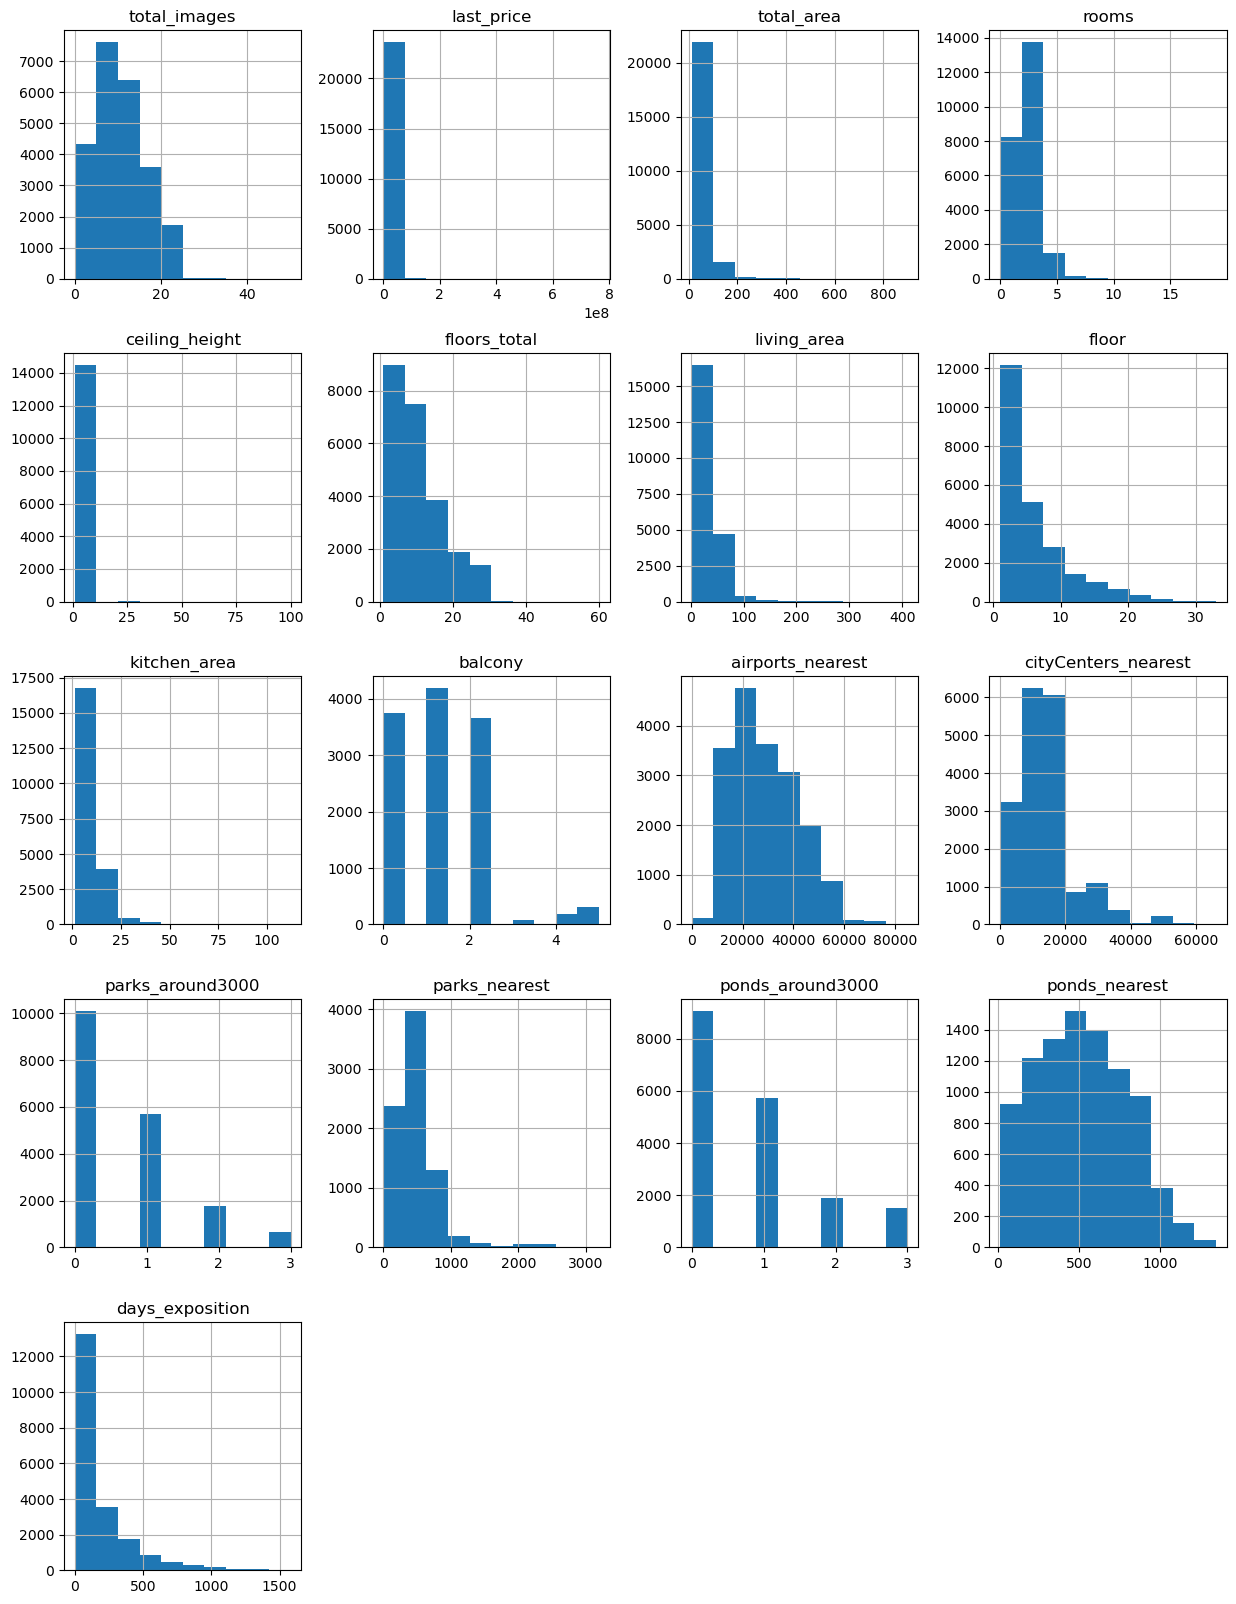

In [11]:
data.hist(figsize=(15, 20))
plt.show()

**Вывод:**

1. К полученным данным был применен разделитель sep при их загрузке, чтобы они не были "склеины" в одну строку.
2. Стоит отредактировать названия столбцов. Например, в "cityCenters_nearest" убрать скачущий регистор, а "rooms", "parks_around3000" и "ponds_around3000" сделать более информативными.
3. С помощью метода info мы получили инофрматию о количестве данных, среди которой видно множество пропусков - их предстоит обработать.
4. Также тип переменных в столбце "first_day_exposition" (дата публикации) задать, как дата.
5. В данных о высоте потолков встречаются аномалии, как очень маленькие значения, так и очень большие - рассмотрим их.

## Предобрабортка данных

Переименуем названия столбцов

In [15]:
data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'cityCenters_nearest',
 'parks_around3000',
 'parks_nearest',
 'ponds_around3000',
 'ponds_nearest',
 'days_exposition']

In [16]:
data = data.rename(
    columns = {
        'cityCenters_nearest': 'city_center_distance',
        'parks_around3000': 'parks_around_3km',
        'ponds_around3000': 'ponds_around_3km'
              }
)

In [17]:
# Проверим

data.columns.tolist()

['total_images',
 'last_price',
 'total_area',
 'first_day_exposition',
 'rooms',
 'ceiling_height',
 'floors_total',
 'living_area',
 'floor',
 'is_apartment',
 'studio',
 'open_plan',
 'kitchen_area',
 'balcony',
 'locality_name',
 'airports_nearest',
 'city_center_distance',
 'parks_around_3km',
 'parks_nearest',
 'ponds_around_3km',
 'ponds_nearest',
 'days_exposition']

Поработаем с пропускми: посмотрим их количество и решим, что можно с ними сделать. Для этого представим их количество в процентак, используя градиент, чтобы оценить можно ли их просто удалить

In [225]:
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,0.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,0.000000


Количество строк без названия города = 49. На фоне всего датафрейма - это количество незначительно, удалим эти строки.

In [21]:
data = data.dropna(subset=['locality_name'])

Далее рассмотрим колонку "is_apartment" - она принимает три вида значений True, False, NaN. Логично было бы заменить значение NaN на False

In [23]:
data['is_apartment'] = data['is_apartment'].fillna(False)
data['is_apartment'] = data['is_apartment'].astype(bool)

C:\Users\Евгений\AppData\Local\Temp\ipykernel_15604\1599987838.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['is_apartment'] = data['is_apartment'].fillna(False)


Обработаем столбец с количеством балконов: во-первых, сделаем тип данных int - так мы уйдем от дробных чисел, так как не может быть 1,5 балкона. Во-вторых, заменим пропуски на 0.

In [25]:
data['balcony'] = data['balcony'].fillna(0)

In [26]:
data['balcony'] = pd.to_numeric(data['balcony']).astype('int')

In [27]:
sorted(data['ceiling_height'].unique().tolist())

[1.0,
 2.0,
 2.3,
 2.4,
 2.45,
 2.46,
 2.48,
 2.53,
 2.59,
 2.62,
 2.63,
 2.7,
 nan,
 1.2,
 1.75,
 2.2,
 2.25,
 2.34,
 2.47,
 2.49,
 2.5,
 2.51,
 2.52,
 2.54,
 2.55,
 2.56,
 2.57,
 2.58,
 2.6,
 2.61,
 2.64,
 2.65,
 2.66,
 2.67,
 2.68,
 2.69,
 2.71,
 2.72,
 2.73,
 2.74,
 2.75,
 2.76,
 2.77,
 2.78,
 2.79,
 2.8,
 2.81,
 2.82,
 2.83,
 2.84,
 2.85,
 2.86,
 2.87,
 2.88,
 2.89,
 2.9,
 2.91,
 2.92,
 2.93,
 2.94,
 2.95,
 2.96,
 2.97,
 2.98,
 2.99,
 3.0,
 3.01,
 3.02,
 3.03,
 3.04,
 3.05,
 3.06,
 3.07,
 3.08,
 3.09,
 3.1,
 3.11,
 3.12,
 3.13,
 3.14,
 3.15,
 3.16,
 3.17,
 3.18,
 3.2,
 3.21,
 3.22,
 3.23,
 3.24,
 3.25,
 3.26,
 3.27,
 3.28,
 3.29,
 3.3,
 3.31,
 3.32,
 3.33,
 3.34,
 3.35,
 3.36,
 3.37,
 3.38,
 3.39,
 3.4,
 3.42,
 3.43,
 3.44,
 3.45,
 3.46,
 3.47,
 3.48,
 3.49,
 3.5,
 3.51,
 3.52,
 3.53,
 3.54,
 3.55,
 3.56,
 3.57,
 3.58,
 3.59,
 3.6,
 3.62,
 3.63,
 3.65,
 3.66,
 3.67,
 3.68,
 3.69,
 3.7,
 3.75,
 3.76,
 3.78,
 3.8,
 3.82,
 3.83,
 3.84,
 3.85,
 3.86,
 3.87,
 3.88,
 3.9,
 3.93,
 3.95,


Рассмотрим высоту потолков: среди данных с размером потолков встречаются аномальные значения. Например, 25.0, 24.0, 32.0, 27.5 - данные значения можно разделить на 10, тогда они станут правдоподобными. Для этого напишем цикл. А такие значения как 14.0, 100.0, 1.2, 1.75, 1.0 - заменим на Nan с помощью библиотеки Numpy

In [29]:
for index, value in data['ceiling_height'].items():
    if value > 20:
        data.at[index, 'ceiling_height'] = value / 10

Пропуски в высоте потолков заменим на медиану

In [31]:
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median())

В столбце с количеством этажей в доме удалим строки с пропусками, так как их количество незначительно

In [33]:
data = data.dropna(subset=['floors_total'])

Так как буква "ё" дает дубликаты, заменим ее на "е". А также приведем строки к нижнему регистру

In [35]:
display(data.isnull().sum().sort_values())

total_images                0
locality_name               0
balcony                     0
open_plan                   0
is_apartment                0
floor                       0
studio                      0
ceiling_height              0
rooms                       0
first_day_exposition        0
total_area                  0
last_price                  0
floors_total                0
living_area              1865
kitchen_area             2222
days_exposition          3171
parks_around_3km         5500
ponds_around_3km         5500
city_center_distance     5501
airports_nearest         5524
ponds_nearest           14529
parks_nearest           15535
dtype: int64

Обработаем названия городов: уберем букву Ё и приведем все к нижнему регистру, чтобы избавиться от дубликатов, котрые могут повлияться на результаты

In [37]:
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True)
data['locality_name'] = data['locality_name'].str.lower()

Переформатируем столбец "first_day_exposition" (дата публикации) из типа объект в тип дата (Формат: %Y-%m-%dT%H:%M:%S)

Данное преобразование поможет нам в дальнейшем работать с колонкой даты. Например, создать на ее основе колонки с днями недели

In [39]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format="%Y-%m-%dT%H:%M:%S")

In [40]:
# Сделаем проверку на явные дубликаты

data.duplicated().sum()

0

**Вывод**

В результате осуществленной обработки данных нам удалось выполнить несколько важных преобразований:

* *Изменение типа данных времени публикации:* Это позволило нам эффективно работать с временными значениями и использовать встроенные методы библиотеки pandas для анализа.

* *Обработка высоты потолков:* Мы избавились от выбросов, которые значительно выделялись на фоне других данных, что улучшило качество анализа.

* *Нормализация названий городов:* Изменение регистра и удаление буквы "ё" помогло устранить дубликаты в названиях, что обеспечило более точные результаты.

* *Корректировка типа данных столбца "балконы":* Мы преобразовали значения в целые числа и заполнили пропуски, что повысило целостность данных.

* *Проверка на дубликаты:* Мы провели проверку данных на наличие явных дубликатов, что дополнительно улучшило их качество и надежность.
Эти шаги способствовали более глубокому и точному анализу, а также подготовили данные для дальнейшей работы.

* *Изменение типов данных:* Мы обработали типы времени и количество балконов, что поможет нам в дальнейшем лучше обработать данные.


## Добавление столбцов

Добавим следующие столбцы для дальнейшего исследования данных:

1. Добавим столбец price_per_meter - цена за один м2 и округлим ее до целого числа. Для этого разделим общую стоимость на площадь жилья.
2. Добавим столбец с днем публикации объявления, где 0 - понедельник, 1 - вторник и т. д.
3. Добавим столбцы месяца и года публикации объявления.
4. Добавим столбец с типами этажа: первый, последний и другой - для этого используем функцию.
5. Добавим столбец с расстоянием до центра города в км.

In [44]:
data['price_per_meter'] = data['last_price'] / data['total_area']
data['price_per_meter'] = data['price_per_meter'].round(decimals=0)

In [45]:
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday

In [46]:
data['month_exposition'] = data['first_day_exposition'].dt.month_name()
data['year_exposition'] = data['first_day_exposition'].dt.year

In [47]:
data['floor_type'] = data.apply(floor_type, axis=1)

In [48]:
data['city_center_distance_km'] = (data['city_center_distance'] / 1000).round(decimals=0)

In [49]:
data.head(10)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distance_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.00,8,False,...,482.0,2.0,755.0,NaN,120370.0,3,March,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.60,1,False,...,NaN,0.0,NaN,81.0,82921.0,1,December,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.30,4,False,...,90.0,2.0,574.0,558.0,92786.0,3,August,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.0,4,July,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.00,13,False,...,112.0,1.0,48.0,121.0,100000.0,1,June,2018,другой,8.0
5,10,2890000.0,30.40,2018-09-10,1,2.65,12.0,14.40,5,False,...,NaN,NaN,NaN,55.0,95066.0,0,September,2018,другой,NaN
6,6,3700000.0,37.30,2017-11-02,1,2.65,26.0,10.60,6,False,...,NaN,0.0,NaN,155.0,99196.0,3,November,2017,другой,19.0
7,5,7915000.0,71.60,2019-04-18,2,2.65,24.0,NaN,22,False,...,NaN,0.0,NaN,NaN,110545.0,3,April,2019,другой,12.0
8,20,2900000.0,33.16,2018-05-23,1,2.65,27.0,15.43,26,False,...,NaN,NaN,NaN,189.0,87455.0,2,May,2018,другой,NaN
9,18,5400000.0,61.00,2017-02-26,3,2.50,9.0,43.60,7,False,...,NaN,0.0,NaN,289.0,88525.0,6,February,2017,другой,15.0


## Исследовательский анализ данных

В этом разделе мы углубимся в исследовательский анализ данных, чтобы лучше понять структуру и взаимосвязь наших данных. На первом этапе мы уже ознакомились с общей информацией о датасете и распределениями с помощью гистограмм. Теперь пора обратить внимание на каждый параметр индивидуально и провести более детальный анализ.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

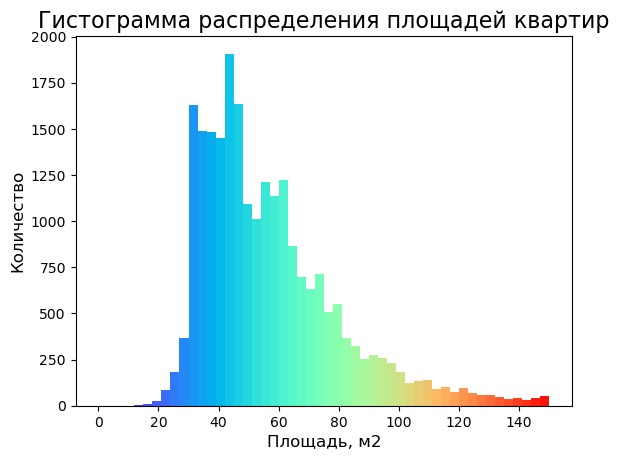

In [52]:
hist(data, 'total_area', 'площадей квартир')

**Вывод:**

Распределение площадей квартир демонстрирует схожесть с распределением Пуассона, не содержит аномальных выбросов и резких пиков. Минимальная площадь составляет 12 кв.м., в то время как максимальная достигает 900 кв.м. Основная часть данных сосредоточена в диапазоне от 12 до 200 кв.м., что указывает на преобладание небольших и средних квартир. Статистические показатели также подчеркивают следующие тенденции: медианное значение площади составляет 52 кв.м., тогда как среднее значение равно 60.3 кв.м. Это подтверждает реальность и адекватность полученных данных для анализируемого набора.

count    21343.000000
mean        10.560994
std          5.900630
min          1.300000
25%          7.000000
50%          9.100000
75%         12.000000
max        112.000000
Name: kitchen_area, dtype: float64

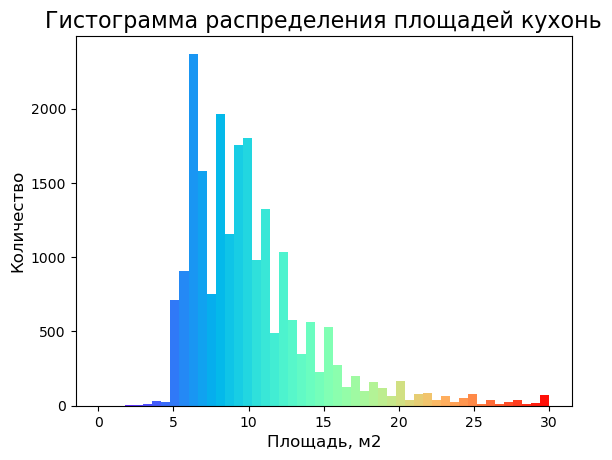

In [54]:
hist(data, 'kitchen_area', 'площадей кухонь', range_num=(0, 30))

**Вывод:**

Гистограмма распределения площадей кухонь в выборке составила 21,343 наблюдения, что позволяет сделать обоснованные выводы о характеристиках кухонных помещений на рынке. Средняя площадь кухни составляет примерно 10.6 м², что указывает на нормальные размеры кухонь, соответствующие большинству современных жилых квартир. Стандартное отклонение в 5.9 м² говорит о наличии значительного разнообразия в площадях кухонь, что отражает диапазон помещений от маленьких до более просторных. Минимальная площадь кухни составляет 1.3 м², что может указывать на наличие очень compact (компактных) кухонных решений, в то время как максимальная площадь достигает 112 м², что предполагает наличие очень больших кухонь, возможно в элитных или загородных жилых комплексах. 25% квартир имеют кухни площадью меньше 7.0 м², в то время как медиана (50%) составляет 9.1 м². Это означает, что половина всех кухонь в выборке имеет площадь около или меньше 9.1 м². 75% кухонь обладают площадью менее 12.0 м², что еще раз подтверждает, что большинство кухонь имеют размеры, характерные для стандартных квартир, без значительных отклонений. Гистограмма распределения показывает явный пик в районе 6 метров, после чего происходит плавное снижение, что может свидетельствовать о более низкой популярности или доступности кухонь с большей площадью. 
Разделение данных на категории, возможно, указывает на предпочтения потребителей к более компактным кухонным решениям, что чаще всего встречается в городских условиях, где пространство ограничено. 

Таким образом, можно заключить, что на рынке представлены в основном маленькие и средние кухни, что соответствует современным тенденциям в дизайне и использованию пространств в жилых зданиях.

count    2.356500e+04
mean     6.540058e+06
std      1.091093e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.646000e+06
75%      6.790000e+06
max      7.630000e+08
Name: last_price, dtype: float64

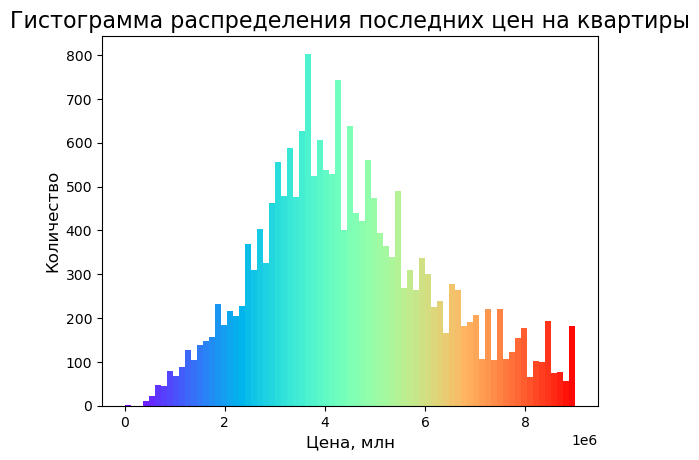

In [56]:
hist(data, 'last_price', 'последних цен на квартиры',xlabel_name='Цена, млн', range_num=(0, 9000000), bins_num=75)

**Вывод:**

Количество наблюдений: В наборе данных содержится 23,565 ценовых наблюдений. Среднее значение: Средняя цена составляет приблизительно 6,54 миллиона, что указывает на то, что цены в целом высоки. Стандартное отклонение: Стандартное отклонение равно 10,91 миллиона, что достаточно высоко, что свидетельствует о наличии значительной вариативности цен в наборе данных. Минимальная и максимальная цена: Минимальное значение составляет 12,19 тысячи, в то время как максимальная цена достигает 763 миллионов, что намекает на наличие дорогих объектов или аномально высоких цен в данных.


count    23565.000000
mean         2.070656
std          1.078591
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

C:\Users\Евгений\AppData\Local\Temp\ipykernel_15604\1295158329.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data[data['rooms'].isin(top_rooms)], x='rooms', palette='viridis', hue=None, legend=False)


<Figure size 1500x600 with 0 Axes>

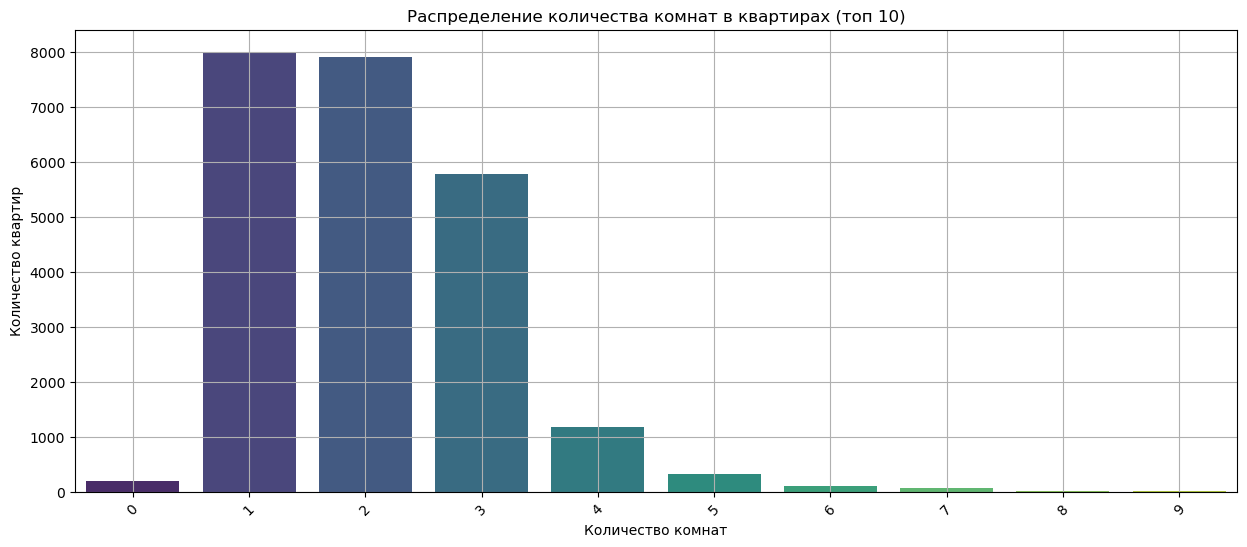

In [58]:
display(data['rooms'].describe())

plt.figure(figsize=(15, 6))

# Получаем 10 наиболее распространённых значений количества комнат
top_rooms = data['rooms'].value_counts().nlargest(10).index

plt.figure(figsize=(15, 6))
sns.countplot(data=data[data['rooms'].isin(top_rooms)], x='rooms', palette='viridis', hue=None, legend=False)

plt.title('Распределение количества комнат в квартирах (топ 10)')
plt.xlabel('Количество комнат')
plt.ylabel('Количество квартир')
plt.xticks(rotation=45)
plt.grid()
plt.show()

**Вывод:**

По данному графику мы видим, что в основном встречаются 1, 2 либо 3 комнаты. В среднем квартиры имеют 2,07 комнаты, что указывает на преобладание малогабаритного жилья, востребованного среди разных категорий покупателей. Стандартное отклонение составляет 1,08, что говорит о разнообразии в количестве комнат, но также подтверждает тенденцию к сосредоточению на небольших квартирах. Минимальное значение равно 0 комнат, что может указывать на наличие студий или нежилых помещений, а также возможные случаи, когда объявления представлены для продажи нежилых объектов.
Максимальное значение составляет 19 комнат, что, вероятно, относится к элитной недвижимости или специальным объектам, таким как гостиницы или большие загородные дома.

Таким образом, анализ показывает, что рынок квартир в основном ориентирован на предложения с 1-3 комнатами, что соответствует текущим потребностям покупателей. Это также открывает возможности для развития предложений в данном сегменте, учитывая высокий интерес к малогабаритным и среднегабаритным вариантам. Разнообразие в количестве комнат также дает возможность проектировать предложения для различных целевых аудиторий, таких как молодые профессионалы, семьи с детьми и пожилые люди.

count    23565.000000
mean         2.699510
std          0.277506
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         20.000000
Name: ceiling_height, dtype: float64

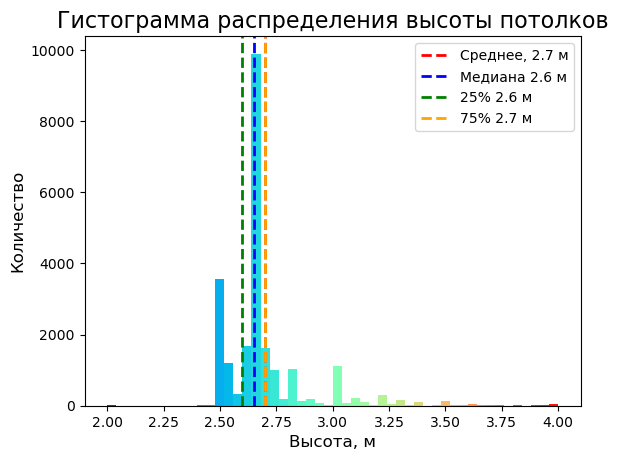

In [60]:
display(data['ceiling_height'].describe())

mean = data['ceiling_height'].mean()
median = data['ceiling_height'].median()
q25 = data['ceiling_height'].quantile(0.25)
q75 = data['ceiling_height'].quantile(0.75)

n, bins, patches = plt.hist(data['ceiling_height'], range=(2, 4), bins=50)

# Применяем радужные цвета
for i in range(len(patches)):
    color = plt.cm.rainbow(i / len(patches)) 
    patches[i].set_facecolor(color)

plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Среднее, {round(mean, 1)} м')
plt.axvline(median, color='blue', linestyle='dashed', linewidth=2, label=f'Медиана {round(median, 1)} м')
plt.axvline(q25, color='green', linestyle='dashed', linewidth=2, label=f'25% {round(q25, 1)} м')
plt.axvline(q75, color='orange', linestyle='dashed', linewidth=2, label=f'75% {round(q75, 1)} м')

plt.title('Гистограмма распределения высоты потолков', fontsize=16)  
plt.ylabel('Количество', fontsize=12)  
plt.xlabel('Высота, м', fontsize=12)  

plt.legend()

plt.show()

**Вывод:**

Средняя высота потолков составляет 2,70 метра. Это значение указывает на то, что большинство квартир имеют стандартные потолки, что соответствует современным требованиям к жилым помещениям. Стандартное отклонение высоты потолков составляет 0,28 метра, что говорит о небольшом разбросе значений. Это подтверждает, что большинство квартир имеют высоту потолков, близкую к среднему значению. Минимальная высота потолков составляет 1 метр, что может указывать на наличие нежилых помещений или объектов с нестандартной планировкой. Максимальная высота потолков достигает 20 метров, что, вероятно, относится к элитной недвижимости или специализированным объектам, таким как пентхаусы или коммерческие помещения.

Таким образом, анализ высоты потолков в квартирах показывает, что основная часть данных расположена в диапазоне от 2,50 до 2,75 метров, что соответствует современным требованиям к жилым помещениям и делает такие квартиры более привлекательными для покупателей.

count    23565.000000
mean         5.878124
std          4.871485
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

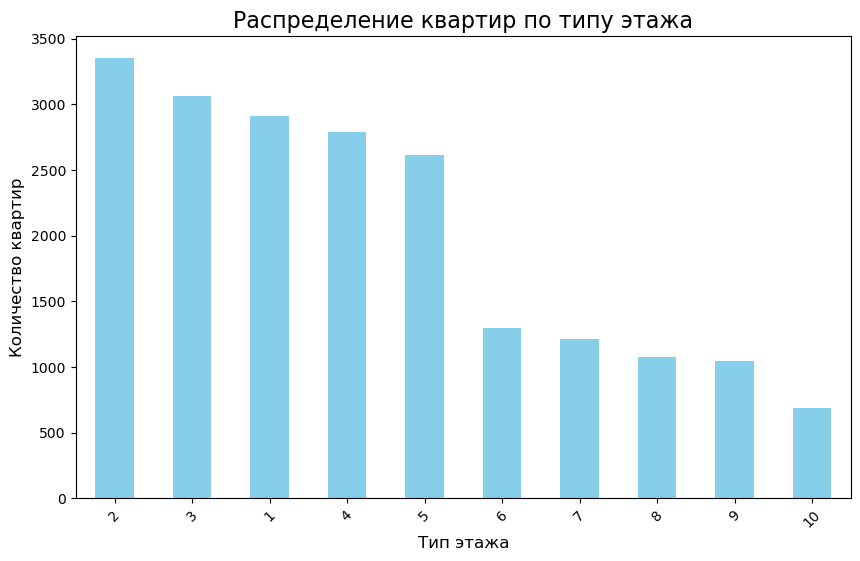

In [62]:
display(data['floor'].describe())

# Получаем 10 наиболее распространённых значений количества комнат
floor_distribution = data['floor'].value_counts().nlargest(10)

plt.figure(figsize=(10, 6))
floor_distribution.plot(kind='bar', color='skyblue')

plt.title('Распределение квартир по типу этажа', fontsize=16)
plt.ylabel('Количество квартир', fontsize=12)
plt.xlabel('Тип этажа', fontsize=12)

plt.xticks(rotation=45)
plt.show()

**Вывод:**

Распределение типов этажей показывает, что большинство квартир находится на нижних и средних этажах. Наличие квартир на первом этаже может быть важно для тех, кто ищет жилье без необходимости подниматься по лестнице. При этом квартиры на более высоких этажах (например, 30+) также представлены, что может привлечь интерес определенной категории людей (например, тех, кто ищет хороший вид или меньший уровень шума). Степень вариабельности типов этажей также указывает на разнообразие в структуре зданий, доступных в выборке.

count    18064.000000
mean        14.186504
std          8.621131
min          0.000000
25%          9.000000
50%         13.000000
75%         16.000000
max         66.000000
Name: city_center_distance_km, dtype: float64

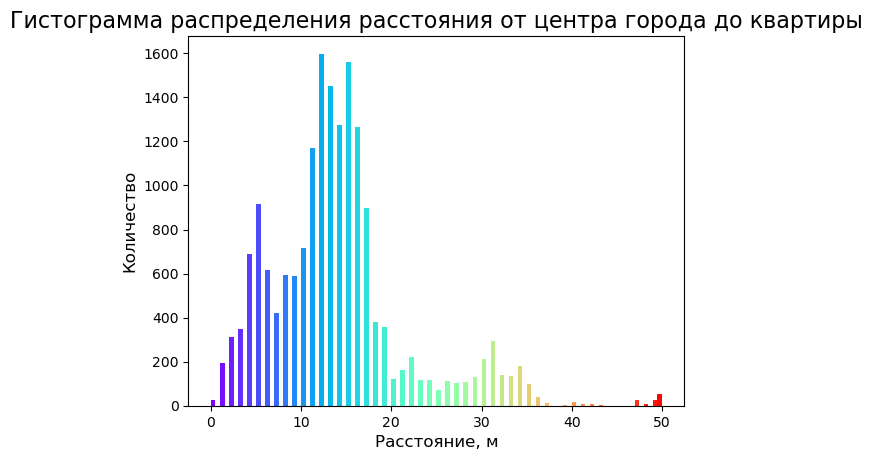

In [64]:
hist(data, 'city_center_distance_km', 
     'расстояния от центра города до квартиры', 
     xlabel_name='Расстояние, м', range_num=(0, 50), bins_num=100)

**Вывод:**

Распределение расстояний от центра города показывает, что большинство квартир находится в пределах 9-16 км от центра. Это может быть важно для людей, которые ищут жилье с хорошей транспортной доступностью к центру. Наличие квартир на расстоянии менее 9 км может привлечь интерес тех, кто предпочитает жить ближе к городской инфраструктуре и услугам. В то же время, квартиры на расстоянии до 66 км могут быть интересны тем, кто ищет более спокойную обстановку или более доступные цены на жилье. Степень вариабельности расстояний также указывает на разнообразие в предложениях жилья, доступных в выборке.

count    8030.000000
mean      490.580448
std       341.572956
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

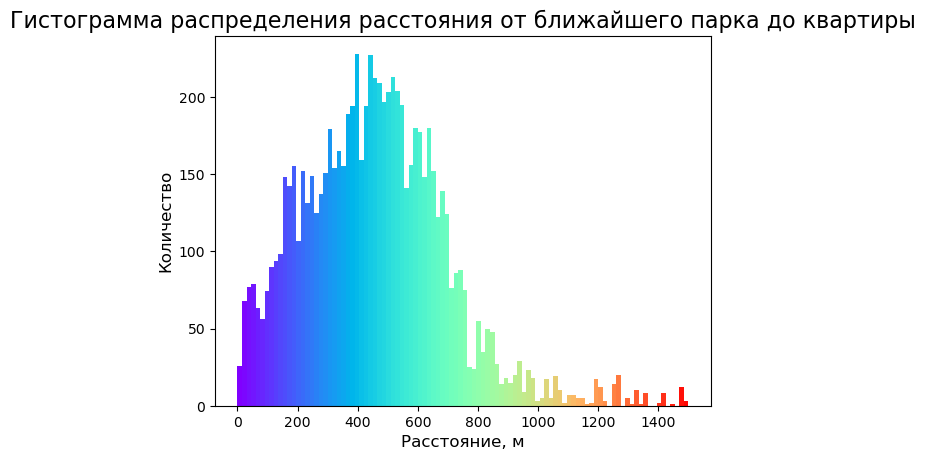

In [66]:
hist(data, 'parks_nearest', 'расстояния от ближайшего парка до квартиры',
     xlabel_name='Расстояние, м', range_num=(0, 1500), bins_num=100)

**Вывод:**

Распределение расстояний от ближайшего парка показывает, что большинство квартир находится в пределах 288-612 метров от зеленых зон. Это может быть важно для людей, которые ценят доступность парков и мест для отдыха на свежем воздухе. Наличие квартир на расстоянии менее 500 метров может привлечь интерес тех, кто предпочитает жить вблизи природных зон. В то же время, квартиры на расстоянии до 3190 метров могут быть интересны тем, кто ищет более доступные варианты жилья, но при этом готов мириться с некоторым удалением от парков. Степень вариабельности расстояний также указывает на разнообразие в предложениях жилья, доступных в выборке.

count    20394.000000
mean       180.741395
std        219.732782
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64

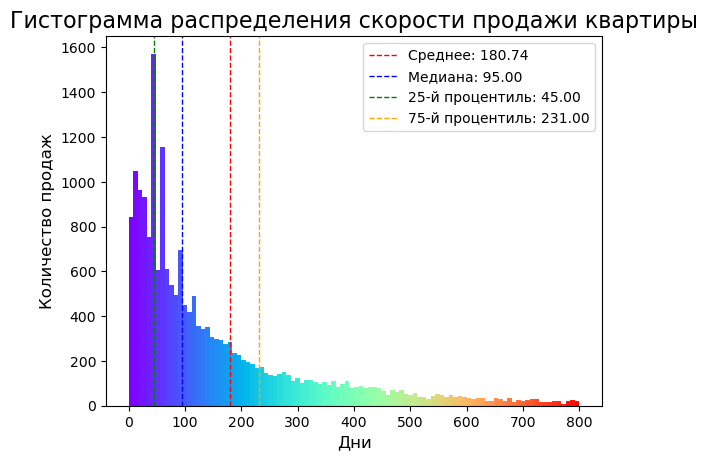

In [68]:
display(data['days_exposition'].describe())

mean_days = data['days_exposition'].mean()
median_days = data['days_exposition'].median()
q25_days = data['days_exposition'].quantile(0.25)
q75_days = data['days_exposition'].quantile(0.75)

n, bins, patches = plt.hist(data['days_exposition'], range=(0, 800), bins=100)

# Применяем радужные цвета
for i in range(len(patches)):
    color = plt.cm.rainbow(i / len(patches)) 
    patches[i].set_facecolor(color)

# Добавляем линии для среднего, медианы и квантилей на график
plt.axvline(mean_days, color='red', linestyle='dashed', linewidth=1, label=f'Среднее: {mean_days:.2f}')
plt.axvline(median_days, color='blue', linestyle='dashed', linewidth=1, label=f'Медиана: {median_days:.2f}')
plt.axvline(q25_days, color='green', linestyle='dashed', linewidth=1, label=f'25-й процентиль: {q25_days:.2f}')
plt.axvline(q75_days, color='orange', linestyle='dashed', linewidth=1, label=f'75-й процентиль: {q75_days:.2f}')

plt.title('Гистограмма распределения скорости продажи квартиры', fontsize=16)  
plt.ylabel('Количество продаж', fontsize=12)  
plt.xlabel('Дни', fontsize=12)  

plt.legend()
plt.show()

**Вывод:**


Среднее значение: В среднем, квартиры продавались 180.74 дня. Это значение показывает, что процесс продажи в среднем занимает более полугода.

Стандартное отклонение: Стандартное отклонение равно 219.73 дня. Высокое значение стандартного отклонения указывает на значительное рассеяние данных вокруг среднего значения. Это означает, что некоторые продажи происходили значительно быстрее или медленнее, чем в среднем.

Минимальное значение: Самая быстрая продажа заняла всего 1 день. Это может свидетельствовать о быстром процессе продажи в особых обстоятельствах, таких как высокий спрос или привлекательная цена.

25-й процентиль : 25% квартир были проданы за 45 дней или меньше. Это говорит о том, что значительная часть продаж происходила довольно быстро.

Медиана (50%): Медиана продаж составила 95 дней. Половина продаж происходила быстрее, чем за 95 дней, и половина — медленнее. Это более надёжный показатель центральной тенденции, чем среднее, поскольку не подвержен влиянию выбросов.

75-й процентиль (75%): 75% продаж занимали 231 день или меньше. Это предполагает, что только одна четверть продаж превышала этот срок, что может указывать на возможные проблемы со спросом или уникальные характеристики предлагаемых объектов недвижимости.

Максимальное значение (max): Долгий процесс продажи максимальной квартиры составил 1580 дней. Это может указывать на определенные проблемы, такие как неудачная цена, особенности объекта или те, что квартира находилась на рынке достаточно долго.
Общий вывод:

Данные о днях, потраченных на продажу квартир, показывают значительное разнообразие в сроках продажи. Среднее значение и медиана указывают на довольно длительный процесс, однако наличие значительных отклонений подразумевает, что некоторые квартиры могут быть как реализованы очень быстро, так и оставаться непроданными в течение длительного времени. Это может свидетельствовать о различиях в спросе в зависимости от месторасположения, ценового сегмента и других факторов.

### Факторы, влияющие на полную стоимость объекта

Чтобы сделать вывод о факторах, влияющих на полную стоимость квартиры, используем корреляционный анализ данных

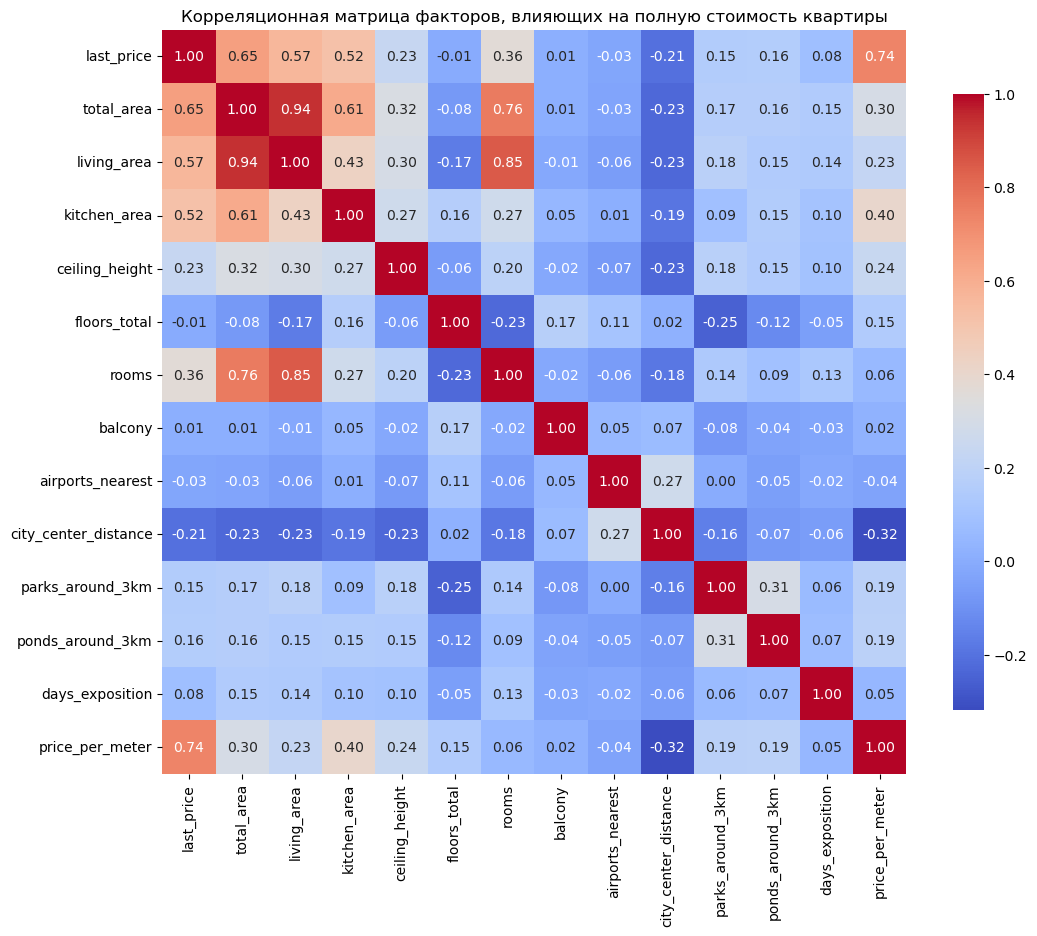

In [72]:
numeric_columns = [
    'last_price', 'total_area', 'living_area', 'kitchen_area', 
    'ceiling_height', 'floors_total', 'rooms', 'balcony', 
    'airports_nearest', 'city_center_distance', 'parks_around_3km', 
    'ponds_around_3km', 'days_exposition', 'price_per_meter'
]

correlation_matrix = data[numeric_columns].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            square=True, 
            cbar_kws={"shrink": .8})

plt.title('Корреляционная матрица факторов, влияющих на полную стоимость квартиры')
plt.show()

**Выводы на основе корреляционного анализа факторов, влияющих на цену квартиры:**

1. Площадь квартиры: Корреляция между последней ценой квартиры и общей площадью составляет 0.65. Это указывает на сильную положительную связь, что означает, что с увеличением площади квартиры, как правило, увеличивается и ее цена.

2. Удаление от центра города: Корреляция между ценой и расстоянием до центра города равна -0.21, что свидетельствует о слабой отрицательной связи. Это означает, что квартиры, расположенные ближе к центру, имеют тенденцию к более высокой цене.

3. Жилая площадь: Корреляция между ценой и жилой площадью составляет 0.57. Это также указывает на положительную связь, что говорит о том, что квартиры с большей жилой площадью, как правило, стоят дороже.

4. Высота потолков: Корреляция между ценой и высотой потолков равна 0.23, что указывает на слабую положительную связь. Это может означать, что квартиры с более высокими потолками могут иметь немного более высокую цену.

5. Количество комнат: Корреляция между ценой и количеством комнат составляет 0.36, что указывает на умеренную положительную связь. Это говорит о том, что квартиры с большим количеством комнат, как правило, стоят дороже.

6. Количество балконов: Корреляция между ценой и количеством балконов равна 0.01, что указывает на отсутствие значимой связи. Это означает, что наличие балконов не влияет на цену квартиры.

7. Расстояние до ближайшего аэропорта: Корреляция между ценой и расстоянием до ближайшего аэропорта составляет -0.03, что также указывает на отсутствие значимой связи. Это говорит о том, что расстояние до аэропорта не влияет на стоимость квартиры.

8. Количество водоемов в радиусе 3 км: Корреляция между ценой и количеством водоемов в радиусе 3 км равна 0.16, что указывает на слабую положительную связь. Это может означать, что наличие водоемов в окрестностях может немного повышать стоимость квартиры.

В целом, наиболее значительными факторами, влияющими на цену квартиры, являются общая площадь и жилая площадь, в то время как количество балконов и расстояние до аэропорта не оказывают заметного влияния на стоимость.

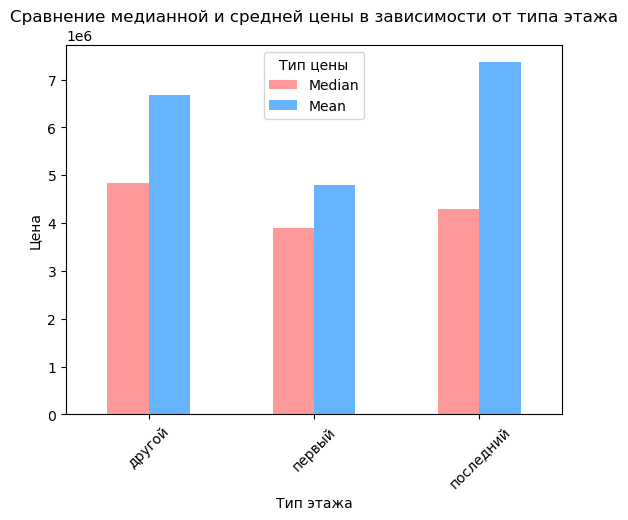

In [136]:
plot_info(data, 'floor_type', 'last_price', 'типа этажа', 'Тип этажа')

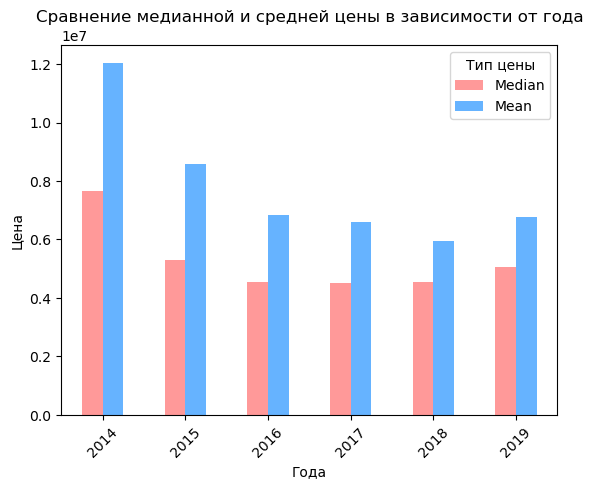

In [140]:
plot_info(data, 'year_exposition', 'last_price', 'года', 'Года')

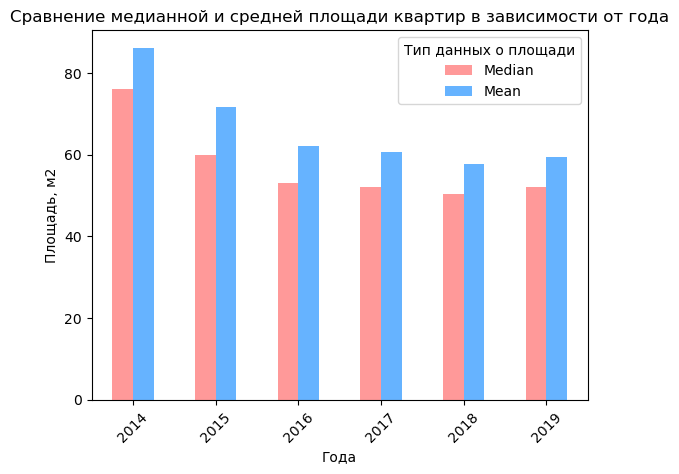

In [158]:
df_median = data.pivot_table(index='year_exposition', values='total_area', aggfunc='median')
df_mean = data.pivot_table(index='year_exposition', values='total_area', aggfunc='mean')

data_combined = pd.DataFrame({
    'Median': df_median['total_area'],
    'Mean': df_mean['total_area']
})

data_combined.plot(kind='bar', color=['#FF9999', '#66B3FF'])

plt.title('Сравнение медианной и средней площади квартир в зависимости от года')
plt.ylabel('Площадь, м2')
plt.xlabel("Года")
plt.xticks(rotation=45)
plt.legend(title='Тип данных о площади')
plt.show()

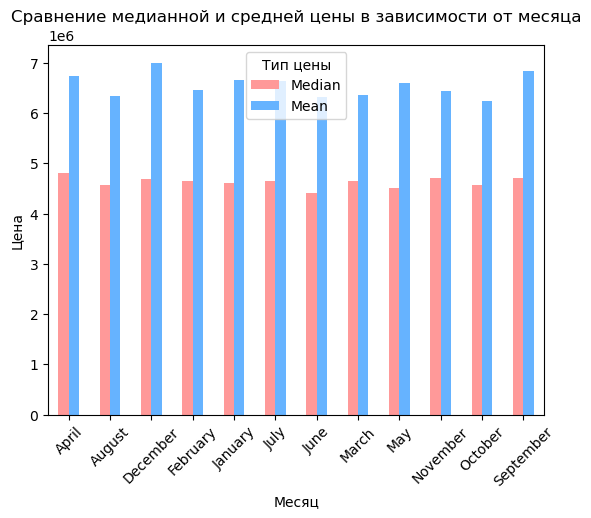

In [144]:
plot_info(data, 'month_exposition', 'last_price', 'месяца', 'Месяц')

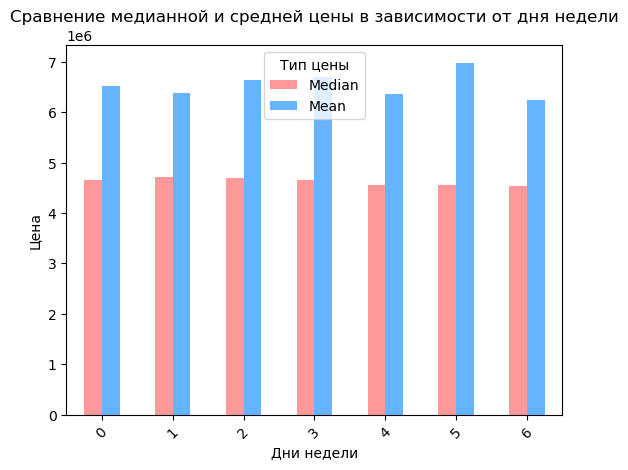

In [146]:
plot_info(data, 'day_of_week_exposition', 'last_price', 'дня недели', 'Дни недели')

**Вывод:**

*Сравнение цен по типу этажа:*

Средняя цена первого этажа ниже, чем у остальных этажей. Это может указывать на то, что покупатели менее предпочитают квартиры на первом этаже, возможно, из-за опасений по поводу безопасности, шума или недостатка солнечного света. Это распространенная тенденция на рынке недвижимости.

*Цены по годам:*

Заметим, что с 2015 года цены начали снижаться. Это может быть связано с экономическими факторами, такими как кризисы, изменения в законодательстве или другие внешние обстоятельства, которые могли повлиять на рынок недвижимости. Но проанализировав график распределения площадей продаваемых квартир в зависимсоти от года, можно увидеть, что квартиры начали плодаваться с меньшей площадью, начиная с 2015 года. Это возможно, из-за экономической нестабильности или изменения в образе жизни или же может быть связано с ростом цен на недвижимость, когда покупатели стремятся уложиться в бюджет.

*Сезонные колебания цен:*

Летние месяцы с самыми низкими ценами могут указывать на то, что в это время года спрос на квартиры снижается, возможно, из-за отпусков и меньшей активности на рынке. В то же время, декабрь и сентябрь с высокими ценами могут быть связаны с тем, что в эти месяцы происходит больше сделок, возможно, из-за того, что люди стремятся завершить покупки до конца года или перед началом учебного года.

*Зависимость от дней недели:*

Отсутствие заметной зависимости от дней недели может говорить о том, что рынок недвижимости работает достаточно стабильно, и покупатели не привязывают свои решения к конкретным дням. 

### Анализ средней цены одного квадратного метра у 10 населенных пунктов с наибольшим числом объявлений

In [194]:
# Список и срез 10 населённых пунктов с наибольшим числом объявлений

list =  data['locality_name'].value_counts().head(10).index
top_ten = data.query('locality_name in @list')

display(list)
display(top_ten)

Index(['санкт-петербург', 'поселок мурино', 'поселок шушары', 'всеволожск',
       'пушкин', 'колпино', 'поселок парголово', 'гатчина', 'деревня кудрово',
       'выборг'],
      dtype='object', name='locality_name')

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distance_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.0,3,March,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,False,...,NaN,0.0,NaN,81.0,82921.0,1,December,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92786.0,3,August,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.0,4,July,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.0,1,June,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23689,13,3550000.0,35.30,2018-02-28,1,2.86,15.0,16.3,4,False,...,353.0,2.0,652.0,29.0,100567.0,2,February,2018,другой,16.0
23690,3,5500000.0,52.00,2018-07-19,2,2.65,5.0,31.0,2,False,...,300.0,0.0,NaN,15.0,105769.0,3,July,2018,другой,6.0
23691,11,9470000.0,72.90,2016-10-13,2,2.75,25.0,40.3,7,False,...,NaN,1.0,806.0,519.0,129904.0,3,October,2016,другой,4.0
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,False,...,796.0,3.0,381.0,NaN,72491.0,1,March,2017,другой,4.0


In [196]:
# Найдем среднюю цену квадратного метра для каждого населённого пункта и округлим его

top_ten.pivot_table(
    index = 'locality_name', 
    values = 'price_per_meter', 
    aggfunc = 'mean'
).sort_values(by = 'price_per_meter').round(decimals=0)

,price_per_meter
locality_name,
выборг,58142.0
всеволожск,68654.0
гатчина,68746.0
колпино,75425.0
поселок шушары,78551.0
поселок мурино,85630.0
поселок парголово,90176.0
деревня кудрово,92474.0
пушкин,103126.0


In [198]:
# Найдем медиану цены квартир в наших 10 населенных пнктах

top_ten.pivot_table(index = 'locality_name', values = 'last_price', aggfunc = 'median').sort_values(by = 'last_price')

,last_price
locality_name,
выборг,2897000.0
гатчина,3100000.0
поселок мурино,3400000.0
всеволожск,3450000.0
колпино,3600000.0
деревня кудрово,3790000.0
поселок шушары,3950000.0
поселок парголово,4100000.0
пушкин,5180000.0


**Вывод:**

Средняя цена на квадратный метр значительно ниже в Выборге и постепенно увеличивается по мере продвижения к Санкт-Петербургу. Это может указывать на то, что более удаленные районы имеют более доступные цены, в то время как центральные районы, такие как Санкт-Петербург, имеют высокие цены из-за спроса и ограниченного предложения.

Медианные цены: Медианные цены на квартиры также показывают аналогичную тенденцию. Выборг и Гатчина имеют более низкие медианные цены, что может свидетельствовать о том, что в этих районах доступны более доступные варианты жилья. В то же время, Санкт-Петербург и Пушкин имеют значительно более высокие медианные цены, что может быть связано с более высоким уровнем жизни и спросом на жилье в этих районах.


### Средняя стоимость квартир на разном удалении от центраа в Санкт-Петербурге

In [203]:
spb_flat = data.query('locality_name == "санкт-петербург"')
spb_flat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around_3km,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distance_km
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,482.0,2.0,755.0,NaN,120370.0,3,March,2019,другой,16.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,90.0,2.0,574.0,558.0,92786.0,3,August,2015,другой,14.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,False,...,84.0,3.0,234.0,424.0,408176.0,4,July,2015,другой,7.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,112.0,1.0,48.0,121.0,100000.0,1,June,2018,другой,8.0
7,5,7915000.0,71.6,2019-04-18,2,2.65,24.0,NaN,22,False,...,NaN,0.0,NaN,NaN,110545.0,3,April,2019,другой,12.0


In [205]:
# Посмотрим количество объявлений без расстояния до центра в СПБ

spb_flat['city_center_distance'].isna().sum()

60

In [215]:
spb_flat.loc[:, 'centr_ratio'] = (spb_flat['city_center_distance'] / 1000).astype('float') 
spb_flat.loc[:, 'centr_ratio'] = spb_flat['centr_ratio'].fillna(spb_flat['centr_ratio'].median())
spb_flat.loc[:, 'centr_ratio'] = spb_flat['centr_ratio'].astype('int', errors='ignore')  

spb_flat.head()

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around_3km,ponds_nearest,days_exposition,price_per_meter,day_of_week_exposition,month_exposition,year_exposition,floor_type,city_center_distance_km,centr_ratio
0,20,13000000.0,108.0,2019-03-07,3,2.70,16.0,51.0,8,False,...,2.0,755.0,NaN,120370.0,3,March,2019,другой,16.0,16.0
2,10,5196000.0,56.0,2015-08-20,2,2.65,5.0,34.3,4,False,...,2.0,574.0,558.0,92786.0,3,August,2015,другой,14.0,13.0
3,0,64900000.0,159.0,2015-07-24,3,2.65,14.0,NaN,9,False,...,3.0,234.0,424.0,408176.0,4,July,2015,другой,7.0,6.0
4,2,10000000.0,100.0,2018-06-19,2,3.03,14.0,32.0,13,False,...,1.0,48.0,121.0,100000.0,1,June,2018,другой,8.0,8.0
7,5,7915000.0,71.6,2019-04-18,2,2.65,24.0,NaN,22,False,...,0.0,NaN,NaN,110545.0,3,April,2019,другой,12.0,11.0


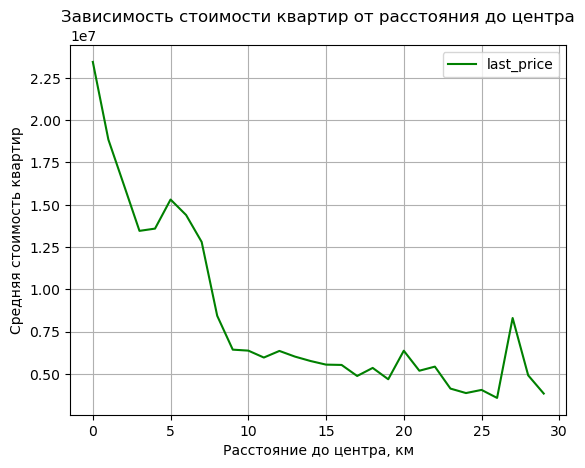

In [221]:
pivot_table_spb = spb_flat.pivot_table(index='centr_ratio', values='last_price', aggfunc='mean')

pivot_table_spb.plot(y='last_price', title='Зависимость стоимости квартир от расстояния до центра', color='green')
plt.xlabel('Расстояние до центра, км')
plt.ylabel('Средняя стоимость квартир')
plt.grid()
plt.show()

## Общий вывод

**В ходе данного иследования были выполнены следующие действия:**

* предобработка данных,
* удаление дубликатов явных и неявных,
* заполение пропущенных значений,
* исправление аномальных данных,
* типизация и категоризация данных,
* добавлены новые столбцы для дальнейшей работы с этими данными.

**В ходе анализа полученных данных был построренны графики и гистограммы, на основе которых можно сделать следующие выводы:**

* Распределение площадей квартир показывает, что большинство объектов находятся в диапазоне от 12 до 200 кв.м., что свидетельствует о преобладании небольших и средних квартир на рынке.

* Средняя площадь составляет 60,3 кв.м., а медианная — 52 кв.м., что подтверждает адекватность полученных данных для анализа.

* На рынке представлены в основном квартиры с 1-3 комнатами, что соответствует современным потребностям покупателей.

* Общее количество наблюдений составляет 23,565, что обеспечивает надежность статистических выводов.

* Средняя цена квартир составляет около 6,54 миллиона, что указывает на высокие ценовые уровни в данном сегменте.

* Высокое стандартное отклонение (10,91 миллиона) свидетельствует о значительной вариативности цен, включая наличие дорогих объектов.

* Разнообразие в количестве комнат позволяет проектировать предложения для различных целевых аудиторий, включая молодежь, семьи с детьми и пожилых людей.

* Большинство квартир расположено на нижних и средних этажах, что привлекает покупателей, ищущих удобный доступ без лестницы, в то время как квартиры на высоких этажах интересуют тех, кто ценит вид и меньший уровень шума.  

* Большинство квартир находится в пределах 9-16 км от центра города, что обеспечивает хорошую транспортную доступность, а также есть предложения ближе к центру и на расстоянии до 66 км для желающих жить в более спокойной обстановке.  

* Большинство квартир расположено на расстоянии 288-612 метров от ближайших парков, с интересом к жилью, находящемуся менее чем в 500 метрах от зеленых зон.  

* В данных о днях, потраченных на продажу квартир, присутствует значительная вариабельность, что может указывать на различия в спросе в зависимости от месторасположения и ценового сегмента.  

* На цену квартиры значительное влияние оказывают общая и жилая площадь, в то время как количество балконов и расстояние до аэропорта не играют заметной роли.

* Средняя цена квартир на первом этаже ниже, чем у остальных этажей, что может указывать на меньшую привлекательность таких квартир для покупателей из-за опасений по поводу безопасности, шума или недостатка солнечного света.

* С 2015 года цены начали снижаться, как и стали уменьшаться площади продаваемых квартир.

* Летние месяцы с низкими ценами могут указывать на снижение спроса, в то время как декабрь и сентябрь с высокими ценами связаны с увеличением сделок в эти месяцы.

* Отсутствие заметной зависимости от дней недели говорит о стабильности рынка недвижимости.

* Средняя цена на квадратный метр значительно ниже в Выборге и постепенно увеличивается по мере приближения к Санкт-Петербургу, что указывает на более доступные цены в удаленных районах.

* Медианные цены на квартиры также показывают аналогичную тенденцию, с более низкими значениями в Выборге и Гатчине, что может свидетельствовать о доступности жилья в этих районах. В то же время, Санкт-Петербург и Пушкин имеют значительно более высокие медианные цены, что может быть связано с высоким уровнем жизни и спросом на жилье в этих местах.